In [1]:
from os.path import join
DATA_ROOT = join("./", "data", "cmu_arctic")
!ls $DATA_ROOT

cmu_us_awb_arctic  cmu_us_clb_arctic  cmu_us_ksp_arctic  cmu_us_slt_arctic
cmu_us_bdl_arctic  cmu_us_jmk_arctic  cmu_us_rms_arctic


In [2]:
import matplotlib.pyplot as plt
%pylab inline
plt.rcParams["figure.figsize"] = (16,5)

Populating the interactive namespace from numpy and matplotlib


Import

In [3]:
from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
# from nnmnkwii.preprocessing import DeltaAppender
from nnmnkwii.util import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

#### Setting

In [4]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.03
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [5]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc
    

In [6]:
clb_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["clb"], max_files=max_files)
slt_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["slt"], max_files=max_files)

In [7]:
X = PaddedFileSourceDataset(clb_source, 1200).asarray()
Y = PaddedFileSourceDataset(slt_source, 1200).asarray()
print(X.shape)
print(Y.shape)

(97, 1200, 25)
(97, 1200, 25)


### PlotData

In [14]:
# Plotting util
def plot_parallel(x,y):
    plt.figure(figsize=(16,7))
    plt.subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    plt.colorbar()
    plt.subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    plt.colorbar()
    

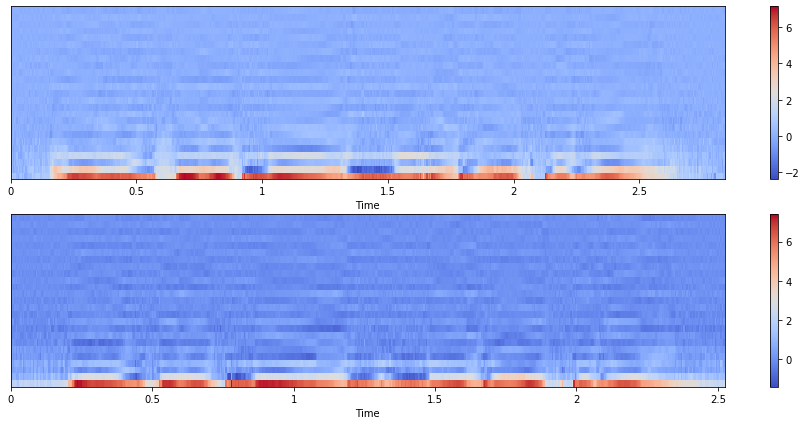

In [15]:
idx = 22 # any
plot_parallel(X[idx],Y[idx])

In [10]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

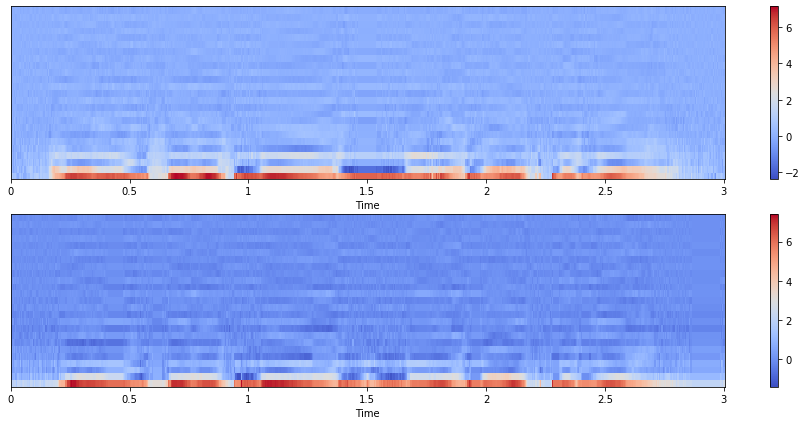

In [12]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [16]:
# Drop 1st (power) dimention
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [ ]:
# static_dim = X_aligned.shape[-1]
# if use_delta:
#     X_aligned = DeltaAppender(windows).transform(X_aligned)
#     Y_aligned = DeltaAppender(windows).transform(Y_aligned)